# Système Multi-Agents avec Q-Learning - Démonstration Complète

Ce notebook présente l'ensemble des fonctionnalités du système d'ordonnancement hospitalier.

### Objectifs de la démonstration :
1. **Visualisation des données** : Planning initial et contraintes.
2. **Analyse de la Diversité** : Génération et affichage de la **Matrice des Distances** de l'EMP.
3. **Benchmark Slide 25** : Comparaison Métaheuristiques Seules vs SMA (Tableau généré).
4. **Benchmark Slide 26** : Comparaison Collaboration Amis vs Ennemis (Tableau généré).
5. **Visualisation Finale** : Courbes de convergence et Gantt optimisé.

In [1]:
# 1. Configuration et Imports
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Ajout du chemin racine
sys.path.insert(0, os.path.abspath(os.getcwd()))

# Imports du Core
from core.environment import create_default_environment
from core.neighborhoods import NeighborhoodManager
from core.shared_memory import SharedMemoryPool, Solution
from core.agents import MultiAgentSystem, CollaborationMode
from visualization import plot_gantt, plot_convergence

# Configuration visuelle
plt.style.use('seaborn-v0_8-whitegrid')
random.seed(42)
np.random.seed(42)

print("✓ Environnement chargé avec succès.")

✓ Environnement chargé avec succès.


## 2. Analyse de la Diversité (Matrice des Distances)

L'Espace Mémoire Partagé (EMP) utilise une distance de Hamming adaptée pour maintenir la diversité. Visualisons cette matrice.

Génération de solutions pour la matrice de diversité...


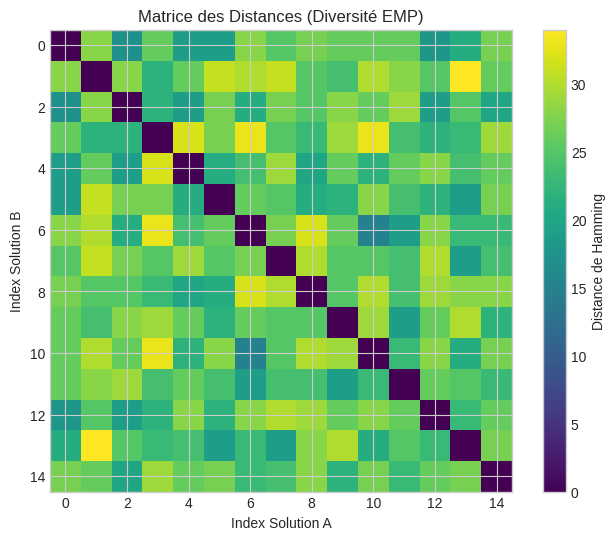

In [2]:
def plot_diversity_heatmap(emp, title="Matrice des Distances (Diversité EMP)"):
    """Génère une heatmap des distances entre les solutions de l'EMP."""
    solutions = emp.solutions
    n = len(solutions)
    
    if n < 2:
        print("Pas assez de solutions pour afficher la matrice.")
        return

    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Calcul de la distance via la méthode interne de l'EMP
            dist = emp.calculate_distance(solutions[i].sequences, solutions[j].sequences)
            matrix[i, j] = dist

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax, label='Distance de Hamming')
    
    ax.set_title(title)
    ax.set_xlabel("Index Solution A")
    ax.set_ylabel("Index Solution B")
    plt.show()

# Simulation : Remplissage de l'EMP avec des solutions aléatoires
env = create_default_environment()
temp_emp = SharedMemoryPool(max_size=20, min_distance=0, diversity_threshold=1.0)

print("Génération de solutions pour la matrice de diversité...")
for i in range(15):
    sol = env.build_initial_solution(random_order=True)
    fit, _, _ = env.evaluate(sol)
    temp_emp.insert(Solution(sol, fit))

plot_diversity_heatmap(temp_emp)

## 3. Benchmark - Tableau 1 (Slide 25)
**Comparaison : Métaheuristiques Seules vs SMA**

Nous lançons des exécutions courtes (50 itérations) pour générer les données du tableau.

In [3]:
def run_quick_scenario(name, mode, q_learn, agents_config, iterations=50):
    """Exécute un scénario et retourne le meilleur makespan."""
    sys_local = MultiAgentSystem(env, mode=mode, use_qlearning=q_learn)
    for type_ag, name_ag, params in agents_config:
        sys_local.add_agent(type_ag, name_ag, **params)
    
    start = time.time()
    best = sys_local.run(n_iterations=iterations, verbose=False)
    dt = time.time() - start
    return best.fitness if best else float('inf'), dt

ITERATIONS = 50
results_table_1 = {}

print(f"Lancement du Benchmark Tableau 1 ({ITERATIONS} itérations par run)...")

# 1. AG Solo
res, t = run_quick_scenario("AG Solo", CollaborationMode.ENEMIES, False, 
                            [('genetic', 'AG', {'population_size': 20})], ITERATIONS)
results_table_1['AG'] = res

# 2. Tabou Solo
res, t = run_quick_scenario("Tabou Solo", CollaborationMode.ENEMIES, False, 
                            [('tabu', 'Tabu', {'tabu_tenure': 10})], ITERATIONS)
results_table_1['Tabu'] = res

# 3. RS Solo
res, t = run_quick_scenario("RS Solo", CollaborationMode.ENEMIES, False, 
                            [('sa', 'RS', {'initial_temp': 100})], ITERATIONS)
results_table_1['RS'] = res

# Configuration SMA (Trio)
trio_config = [
    ('genetic', 'AG', {'population_size': 15}),
    ('tabu', 'Tabu', {'tabu_tenure': 10}),
    ('sa', 'RS', {'initial_temp': 100})
]

# 4. SMA No Learning
res, t = run_quick_scenario("SMA NoLearn", CollaborationMode.FRIENDS, False, trio_config, ITERATIONS)
results_table_1['SMA_NoLearn'] = res

# 5. SMA Learning
res, t = run_quick_scenario("SMA Learn", CollaborationMode.FRIENDS, True, trio_config, ITERATIONS)
results_table_1['SMA_Learn'] = res

# Affichage du Tableau 1
print("\n" + "="*75)
print("  TABLEAU 1 : RÉSULTATS SANS/AVEC COLLABORATION (Inspiré Slide 25)")
print("="*75)
print(f"{'Configuration':<20} | {'Makespan Moyen (Score)':<25} | {'Gain Relatif'}")
print("-"*75)
base = results_table_1['AG']
for key, val in results_table_1.items():
    gain = ((base - val) / base) * 100
    print(f"{key:<20} | {val:<25.1f} | {gain:+.2f}%")
print("="*75)

Lancement du Benchmark Tableau 1 (50 itérations par run)...

  TABLEAU 1 : RÉSULTATS SANS/AVEC COLLABORATION (Inspiré Slide 25)
Configuration        | Makespan Moyen (Score)    | Gain Relatif
---------------------------------------------------------------------------
AG                   | 12.0                      | +0.00%
Tabu                 | 12.0                      | +0.00%
RS                   | 12.0                      | +0.00%
SMA_NoLearn          | 12.0                      | +0.00%
SMA_Learn            | 12.0                      | +0.00%


## 4. Benchmark - Tableau 2 (Slide 26)
**Comparaison : Mode AMIS vs Mode ENNEMIS**

Nous comparons l'efficacité de la collaboration (Partage EMP) vs la compétition (Pool Élite).

In [4]:
print(f"Lancement du Benchmark Tableau 2 (Comparaison Modes)...")

# Configuration pour récupérer l'historique de convergence
mas_amis = MultiAgentSystem(env, mode=CollaborationMode.FRIENDS, use_qlearning=True)
for type_ag, name_ag, params in trio_config:
    mas_amis.add_agent(type_ag, name_ag, **params)

mas_ennemis = MultiAgentSystem(env, mode=CollaborationMode.ENEMIES, use_qlearning=True)
for type_ag, name_ag, params in trio_config:
    mas_ennemis.add_agent(type_ag, name_ag + "_E", **params)

# Exécution
best_amis = mas_amis.run(n_iterations=100, verbose=False)
best_ennemis = mas_ennemis.run(n_iterations=100, verbose=False)

# Affichage Tableau 2
score_amis = best_amis.fitness
score_ennemis = best_ennemis.fitness

print("\n" + "="*60)
print("  TABLEAU 2 : AMIS vs ENNEMIS (Inspiré Slide 26)")
print("="*60)
print(f"{'Mode':<20} | {'Meilleur Makespan':<20} | {'Amélioration'}")
print("-"*60)
print(f"{'Mode ENNEMIS':<20} | {score_ennemis:<20.1f} | Reference")
gain_collab = ((score_ennemis - score_amis) / score_ennemis) * 100
print(f"{'Mode AMIS':<20} | {score_amis:<20.1f} | {gain_collab:+.2f}%")
print("="*60)

Lancement du Benchmark Tableau 2 (Comparaison Modes)...

  TABLEAU 2 : AMIS vs ENNEMIS (Inspiré Slide 26)
Mode                 | Meilleur Makespan    | Amélioration
------------------------------------------------------------
Mode ENNEMIS         | 12.0                 | Reference
Mode AMIS            | 12.0                 | +0.00%


## 5. Visualisations Finales

1. **Courbes de Convergence** : Comparaison de la vitesse de descente entre Amis et Ennemis.
2. **Gantt Final** : Le meilleur planning trouvé par le mode AMIS.

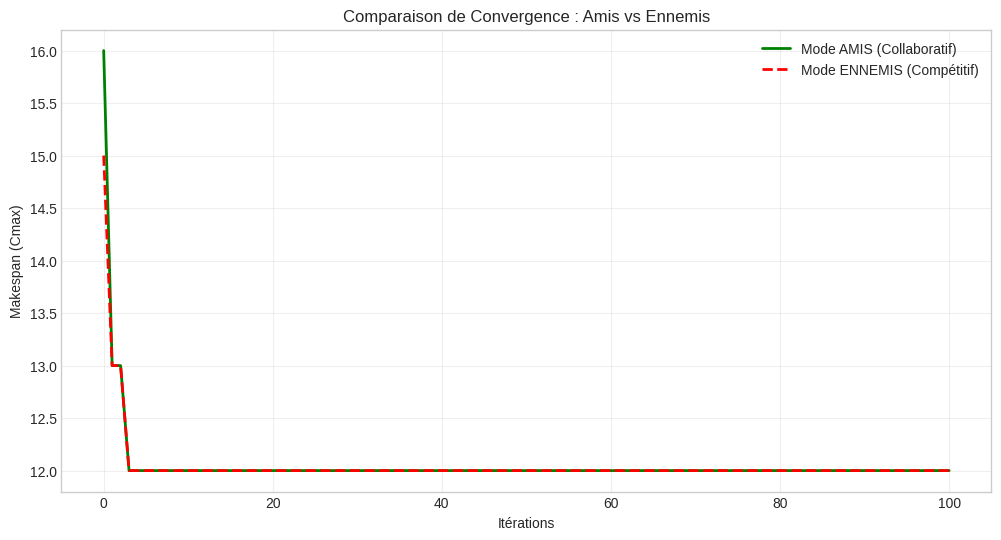

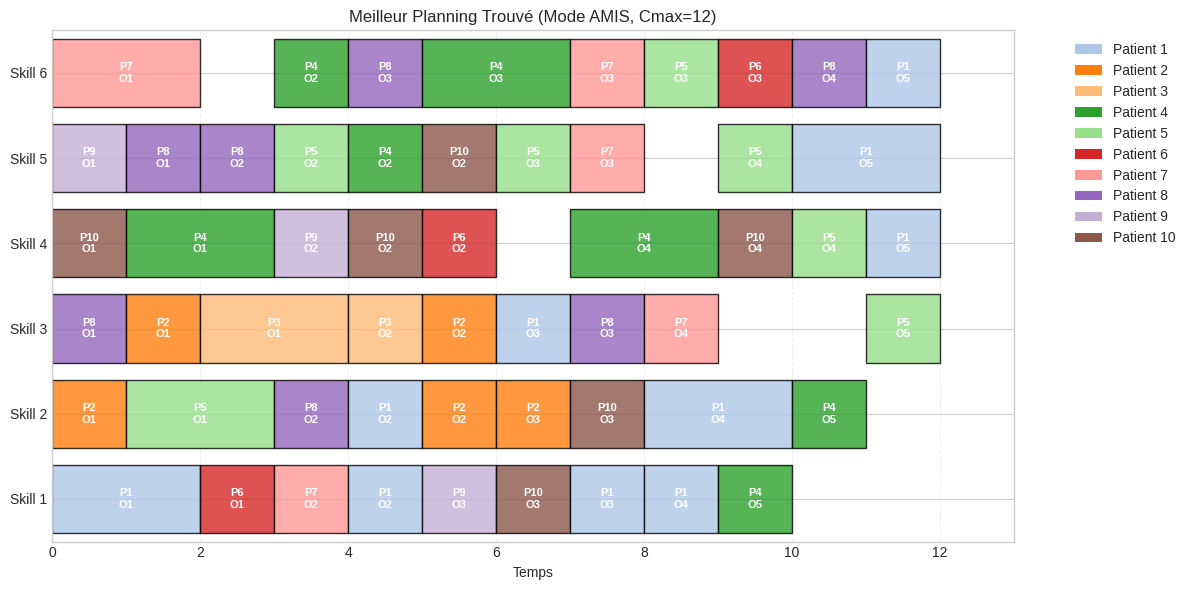

In [5]:
# 1. Courbes de convergence Comparatives
plt.figure(figsize=(12, 6))

# On récupère l'historique du meilleur agent de chaque système pour simplifier
# (ou la fitness globale si stockée, ici on prend l'historique d'un agent représentatif)
hist_amis = mas_amis.agents['AG'].fitness_history
hist_ennemis = mas_ennemis.agents['AG_E'].fitness_history

plt.plot(hist_amis, label='Mode AMIS (Collaboratif)', color='green', linewidth=2)
plt.plot(hist_ennemis, label='Mode ENNEMIS (Compétitif)', color='red', linestyle='--', linewidth=2)

plt.title("Comparaison de Convergence : Amis vs Ennemis")
plt.xlabel("Itérations")
plt.ylabel("Makespan (Cmax)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Gantt Final
final_cmax, final_times, _ = env.evaluate(best_amis.sequences, return_schedule=True)
plot_gantt(
    final_times, env.skills, env.num_patients,
    title=f"Meilleur Planning Trouvé (Mode AMIS, Cmax={final_cmax})"
)